<a href="https://colab.research.google.com/github/BlueBug12/stock/blob/master/hw13_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras

[Keras](https://keras.io/) 是一種較 Tensorflow 更高階的深度學習框架，可以使用更少量的程式碼來建立深度學習模型，可以先熟悉 [Tensorflow 單元](/notebooks/unit/tensorflow/tenforflow.ipynb)後再來閱讀本單元。Keras 使用更低階的深度學習框架作為後端引擎，目前支援如 CNTK、Tensorflow、Theano 等知名框架。本單元將介紹 Keras 中 Model 與 Layer 的用法，並實作一個圖片分類器。

## 1. Model & Layer

在 Keras，可以宣告一個 [Model](https://keras.io/models/about-keras-models/) 物件，並透過加入一層一層的 [Layer](https://keras.io/layers/about-keras-layers/) 來建構一個神經網路，神經網路的運算(例如訓練)都可以透過該 Model 物件來操作。下方程式區段使用了 Keras 中常見的 [Sequential Model](https://keras.io/models/sequential/)，並加入了四種 Layer：

1. [Convolutional Layer](https://keras.io/layers/convolutional/)：卷積層在影像、圖片應用上，表現比全連結層(Keras 的 Dense Layer 更為優異)，參考[卷積神經網絡介紹](https://medium.com/@yehjames/4f8249d65d4f)。
2. [Pooling Layer](https://keras.io/layers/pooling/#maxpooling2d)：池化層的工作是降採樣(down sampling)，以下方程式區段使用的 MaxPooling 為例，將每個 2x2 降採樣為該區域的最大值。
3. [Flatten Layer](https://keras.io/layers/core/#flatten)：將原本多維度的資料拉平成一維，目的是讓前一層的輸出可以接到下一層(通常是全連接層)的輸入。
4. [Dense Layer](https://keras.io/layers/core/#dense)：全連結層。  

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

model = Sequential() # Declare a sequential model

# Add a 2D convolutional layer with 64 nodes, a 3x3 filter and relu as avtivation function
# After this layer, `model.output_shape` is (None, 62, 62, 64)
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))

# Add a 2D max pooling layer that pools the maximun value every 2x2 area
# After this layer, `model.output_shape` is (None, 31, 31, 64)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a flatten layer
# After this layer, `model.output_shape` is (None, 61504)
model.add(Flatten())

# Add a dense layer with 32 nodes and sigmoid as activation function
# After this layer, `model.output_shape` is (None, 32)
model.add(Dense(32, activation='sigmoid'))

# See `model`
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1968160   
Total params: 1,969,952
Trainable params: 1,969,952
Non-trainable params: 0
_________________________________________________________________


## 2. CIFAR-10

CIFAR 的全名為 Canadian Institute for Advanced Research，是由加拿大政府出資並由多位科學家、工程師收集而成的圖片資料庫。[CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) 包含 60000 張 32x32x3 的 RGB 彩色圖片，其中 50000 張為訓練資料，10000 張為測試資料。CIFAR-10 有 10 種類別，0~9 分別對應為：

```
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
```

![CIFAR-10](./cifar_10.png)

Keras 提供[整理好的 CIFAR-10 資料](https://keras.io/datasets/#cifar10-small-image-classification)，只要透過 `import` 就可以拿到對應的訓練與測試資料。用法如下：

170500096/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)

The label of training sample 0 is [6].


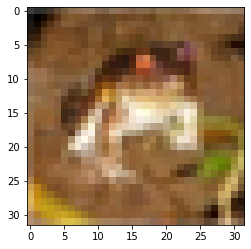

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# see the data shape
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print()

# show the i-th sample of the cifar-10 training set, try a different `i`
i = 0
plt.imshow(x_train[i])
print('The label of training sample %d is %s.' % (i, y_train[i]))

## 3. 範例模型

以下使用 Keras 實作兩種深度學習模型來進行 CIFAR-10 圖片分類。其中 DNN 只使用全連接層，而 CNN 多使用了卷積層。相較於 [Tensorflow 單元](/notebooks/unit/tensorflow/tenforflow.ipynb)的 MNIST 資料，CIFAR-10 的圖片比較複雜且為彩色，更能發揮卷積層的效果。也因此相較於 DNN，CNN 應該更容易得到好的結果。注意比較以下兩個程式區段，使用 CNN 時不需要將圖片 reshape 為一維向量。當然，CNN 也能處理 reshape 過的一維向量。CNN 的初學者可以參考以下連結：

* [A Beginner's Guide To Understanding Convolutional Neural Networks](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/)
* [深度學習(2)--使用Tensorflow實作卷積神經網路(Convolutional neural network，CNN)](http://arbu00.blogspot.tw/2017/03/2-tensorflowconvolutional-neural.html)

![Convolutional Neural Network](https://adeshpande3.github.io/assets/Cover.png)

In [4]:
# DNN

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

x_tr_dnn = x_train[:10000].astype('float32')
x_te_dnn = x_test.astype('float32')

# note that the CNN version does not need to reshape the input
x_tr_dnn = x_tr_dnn.reshape(-1, 3072)
x_te_dnn = x_te_dnn.reshape(-1, 3072)

# normalize
x_tr_dnn /= 255
x_te_dnn /= 255

# one-hot encoding
y_tr_dnn = to_categorical(y_train[:10000], num_classes=10)
y_te_dnn = to_categorical(y_test, num_classes=10)

# options
epochs = 20
batch_size = 128 
learning_rate = 0.001

# model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(3072,)))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# train
model.fit(x_tr_dnn, y_tr_dnn, batch_size=batch_size, epochs=epochs, shuffle=True, validation_data=(x_te_dnn, y_te_dnn))

Epoch 1/20
79/79 [==============================] - 1s 7ms/step - loss: 2.1739 - accuracy: 0.2080 - val_loss: 2.0037 - val_accuracy: 0.2761
Epoch 2/20
79/79 [==============================] - 1s 7ms/step - loss: 1.9803 - accuracy: 0.2853 - val_loss: 1.9444 - val_accuracy: 0.2993
Epoch 3/20
79/79 [==============================] - 0s 6ms/step - loss: 1.9128 - accuracy: 0.3151 - val_loss: 1.8957 - val_accuracy: 0.3260
Epoch 4/20
79/79 [==============================] - 0s 6ms/step - loss: 1.8442 - accuracy: 0.3476 - val_loss: 1.8586 - val_accuracy: 0.3384
Epoch 5/20
79/79 [==============================] - 0s 6ms/step - loss: 1.7992 - accuracy: 0.3655 - val_loss: 1.8229 - val_accuracy: 0.3558
Epoch 6/20
79/79 [==============================] - 0s 6ms/step - loss: 1.7667 - accuracy: 0.3773 - val_loss: 1.8281 - val_accuracy: 0.3514
Epoch 7/20
79/79 [==============================] - 0s 6ms/step - loss: 1.7484 - accuracy: 0.3805 - val_loss: 1.8121 - val_accuracy: 0.3513
Epoch 8/20
79/79 [==

In [8]:
# CNN

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import EarlyStopping
x_tr_cnn = x_train[:50000].astype('float32')
x_te_cnn = x_test.astype('float32')

# normalize
x_tr_cnn /= 255
x_te_cnn /= 255

# one-hot encoding
y_tr_cnn = to_categorical(y_train[:50000], num_classes=10)
y_te_cnn = to_categorical(y_test, num_classes=10)

# options
epochs = 500
batch_size = 128 
learning_rate = 0.001

# model
model = Sequential()

# the input shape for cifar-10 is (32, 32, 3)
# use `Conv2D(#neurons, (filter_size))` to add convolutionary layers
model.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3),padding='same', activation='relu'))

# use `MaxPooling2D()` to add pooling layers
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2),strides=(2,2)))
model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D((2, 2),strides=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(256, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D((2, 2),strides=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(256, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D((2, 2),strides=(2,2)))
'''
model.add(Conv2D(512, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D((2, 2),strides=(2,2)))

model.add(Conv2D(512, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D((2, 2),strides=(2,2)))
'''
#model.add(MaxPooling2D((2, 2)))

# TODO: add more convolutionary and/or pooling layers here

# in practice, fully-connected layers are added after convolutionary and pooling ones 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# train
callback = EarlyStopping(monitor="val_accuracy", patience=10, verbose=1, mode="auto")
#model.fit(x_tr_cnn, y_tr_cnn, batch_size=batch_size, epochs=epochs, shuffle=True, validation_data=(x_te_cnn, y_te_cnn), callbacks=[callback])
model.fit(x_tr_cnn, y_tr_cnn, batch_size=batch_size, epochs=epochs, shuffle=True, validation_data=(x_te_cnn, y_te_cnn))

Epoch 1/500
391/391 [==============================] - 13s 34ms/step - loss: 2.3023 - accuracy: 0.1091 - val_loss: 2.3021 - val_accuracy: 0.1162
Epoch 2/500
391/391 [==============================] - 13s 33ms/step - loss: 2.3006 - accuracy: 0.1437 - val_loss: 2.3000 - val_accuracy: 0.1046
Epoch 3/500
391/391 [==============================] - 13s 33ms/step - loss: 2.2911 - accuracy: 0.1659 - val_loss: 2.2795 - val_accuracy: 0.1803
Epoch 4/500
391/391 [==============================] - 13s 33ms/step - loss: 2.1897 - accuracy: 0.1894 - val_loss: 2.0956 - val_accuracy: 0.2354
Epoch 5/500
391/391 [==============================] - 13s 32ms/step - loss: 2.0697 - accuracy: 0.2319 - val_loss: 2.0992 - val_accuracy: 0.2303
Epoch 6/500
391/391 [==============================] - 13s 33ms/step - loss: 2.0068 - accuracy: 0.2533 - val_loss: 1.9370 - val_accuracy: 0.2806
Epoch 7/500
391/391 [==============================] - 13s 33ms/step - loss: 1.9452 - accuracy: 0.2702 - val_loss: 1.8637 - val_ac

若依照以上範例的設定，經過 20 輪訓練後，DNN 可以到達約 40% 的正確率，而 CNN 可以達到約 50% 的正確率。請更改 DNN 或是 CNN 的架構來改善模型。提示：

1. 調整訓練輪數(`epochs`)
2. 調整批次大小(`batch_size`)
3. 調整學習速率(`learning_rate`)
4. 增加層數
5. 調整每層的神經元數量